# Notebook Initialisation

In [1]:
from os import getcwd, pardir
from os.path import join, abspath

# ! pip install jupyter_nbextensions_configurator jupyter_contrib_nbextensions
# ! jupyter contrib nbextension install
# ! jupyter nbextension install --py fileupload 
# ! jupyter nbextension enable --py fileupload
# ! jupyter nbextension install --py widgetsnbextension 
# ! jupyter nbextension enable --py widgetsnbextension
# ! jupyter nbextensions_configurator enable
# ! jupyter nbextension enable codefolding/main
# ! jupyter nbextension enable toc2/main

! jupyter nbextension enable --py --sys-prefix widgetsnbextension
# init_notebook_mode(connected=True)

## Get Root Directory
rootDirectory = abspath(join(abspath(join(getcwd(), pardir)), pardir))

# `do not disturb` mode
import warnings                                  
warnings.filterwarnings('ignore')

## Create a button that hides cells
from IPython.display import HTML

HTML(
    '''
    <script>
    code_show=true; 
    function code_toggle() {
        if (code_show){
            $('div.input').show();
        } else {
            $('div.input').hide();
        }
        code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Data Load 

In [2]:
from test_utils import *

testsDir = join(rootDirectory, 'smartcitizen-iscape-tests')

def loadButton(b):
    frequency = frequency_text.value + frequency_drop.value
    readings_selected = loadTest(frequency)
    
    for key in readings_selected.keys():
        try:
            readings[key] = dict()
            readings[key] = readings_selected[key]
        except NameError:
            global readings
            readings = dict()
            readings[key] = readings_selected[key]
    

def clearButton(b):
    
    global readings
    clearTests()
    readings = {}

display(widgets.HTML('<hr><h4>Import Local Tests</h4>'))

tests = getTests(testsDir)
interact(selectTests,
         x = widgets.SelectMultiple(options=tests, 
                           selected_labels = selectedTests, 
                           layout=widgets.Layout(width='700px')))

loadB = widgets.Button(description='Load Local Tests')
loadB.on_click(loadButton)

frequency_text = widgets.Text(description = 'Frequency',
                              value = '1',
                              layout = widgets.Layout(width='300px'))
frequency_drop = widgets.Dropdown(options = ['H', 'Min', 'S'],
                                  value = 'Min',
                                  description = '',
                                  layout = widgets.Layout(width='100px'))

frequency_box = widgets.HBox([frequency_text, frequency_drop])

resetB = widgets.Button(description='Clear Tests')
resetB.on_click(clearButton)

buttonBox = widgets.HBox([loadB, resetB])
totalBox = widgets.VBox([frequency_box, buttonBox])
display(totalBox)

------------------------------------------------------


## Test Load

Loading test **2018-10_INT_TEST_TEMP_PM_CHARGE_SD** performed from 2018-10-31 to 2018-11-04

Test performed with commit ****

<hr />
<p><strong>Comment:</strong> 
Test for checking temperature of external and internal SHT31 with the PM and the Charger.
Different recordings with PM ON, OFF, charging and not.</p>

### KIT

#### CHARGE_DISCHARGE_SD_NO_PM

Kit **CHARGE_DISCHARGE_SD_NO_PM** located **Europe/Madrid**

Kit **CHARGE_DISCHARGE_SD_NO_PM** has been loaded

#### CHARGE_SHORT_DISCHARGE_SD_NO_PM

Kit **CHARGE_SHORT_DISCHARGE_SD_NO_PM** located **Europe/Madrid**

Kit **CHARGE_SHORT_DISCHARGE_SD_NO_PM** has been loaded

#### CHARGE_DISCHARGE_SD_PM

Kit **CHARGE_DISCHARGE_SD_PM** located **Europe/Madrid**

Kit **CHARGE_DISCHARGE_SD_PM** has been loaded

------------------------------------------------------


# Test results

## Test with alternating PM

In [3]:
from sklearn.impute import SimpleImputer
    
for device in readings['2018-11_INT_TEST_TEMP_BATT_PM_ON_OFF']['devices']:
    
    _dataframe = None
    _dataframe = readings['2018-11_INT_TEST_TEMP_BATT_PM_ON_OFF']['devices'][device]['data'].copy()
    
    _cols = _dataframe.columns
    print _cols
    _index = _dataframe.index
    
    imputer = SimpleImputer(strategy='median')
    imputer.fit(_dataframe)
    _test = imputer.transform(_dataframe)
    
    columns_rename = ['BATT', 'BATT_CHG_RATE', 'TEMP','EXT_TEMP', 'HUM', 'EXT_HUM','PM_ON_OFF']
    _test_data = pd.DataFrame(imputer.transform(_test), columns = columns_rename)
    _test_data.index = _index
    _test_data.drop_duplicates(inplace=True)
    
    _test_data = _test_data.resample('2S', convention = 'start', kind = 'DateTimeIndex').bfill()
    readings['2018-11_INT_TEST_TEMP_BATT_PM_ON_OFF']['devices'][device]['data'] = _test_data
    
    
    
    print _test_data.head(5)
    print '---------------'

Index([u'Battery', u'Battery charge rate', u'Temperature',
       u'External Temperature', u'Humidity', u'External Humidity',
       u'PM_ON_OFF'],
      dtype='object')
                            BATT  BATT_CHG_RATE   TEMP  EXT_TEMP    HUM  \
Time                                                                      
2018-11-14 19:38:48+01:00  100.0          357.0  26.01    25.395  58.84   
2018-11-14 19:38:50+01:00  100.0          356.0  26.04    25.411  58.82   
2018-11-14 19:38:52+01:00  100.0          355.0  26.03    25.425  59.21   
2018-11-14 19:38:54+01:00  100.0          354.0  26.10    25.467  59.33   
2018-11-14 19:38:56+01:00  100.0          353.0  26.11    25.438  59.12   

                           EXT_HUM  PM_ON_OFF  
Time                                           
2018-11-14 19:38:48+01:00   65.798        0.0  
2018-11-14 19:38:50+01:00   65.715        0.0  
2018-11-14 19:38:52+01:00   65.849        0.0  
2018-11-14 19:38:54+01:00   65.907        0.0  
2018-11-14 19:38

In [47]:
from signal_utils import detect_peak
from formula_utils import exponential_func, evaluate

import matplotlib.pyplot as plot
%matplotlib inline

def count_peak(signal, acum = False, sign = True, init = True):
    count_pos = 0
    count_neg = 0
    if init == True: last_peak_sign = 1 
    else: last_peak_sign = -1
    peak = detect_peak(signal)
    result = np.zeros(signal.shape)
    for i in range(2,len(signal)):
        if acum:
            if peak[i-2] == 1:
                last_peak_sign = 1
                result[i] = 0
            elif peak[i-2] == -1:
                last_peak_sign = -1
                result[i] = 0
            elif peak[i-2] == 0: 
                if i == 0: result[i] = 1
                else: 
                    if sign:
                        result[i] = result[i-1] + last_peak_sign
                    else:
                        result[i] = result[i-1] + 1
        else:
            if peak[i] == 1: 
                count_pos = count_pos + 1
                result[i] = count_pos
            elif peak[i] == -1: 
                count_neg = count_neg + 1
                result[i] = -count_neg
            elif peak[i] == 0: 
                if i == 0: result[i] = 1
                else: result[i] = result[i-1]
    return result

test_data = readings['2018-11_INT_TEST_TEMP_BATT_PM_ON_OFF']['devices']['PM_ON_OFF_FULL']['data'].copy()

test_data['DIFF_TEMP'] = test_data['TEMP'] - test_data['EXT_TEMP']

test_data['CHARGING'] = test_data.loc[:,'BATT_CHG_RATE'] > 0
test_data['TRANSITION_CHARGING'] = detect_peak(test_data['PM_ON_OFF'])
test_data['COUNTER_CHARGING'] = count_peak(test_data['CHARGING'], True, True, test_data['CHARGING'][0])

test_data['TRANSITION_PM_ON_OFF'] = detect_peak(test_data['PM_ON_OFF'])
test_data['COUNTER_PM_ON_OFF'] = count_peak(test_data['PM_ON_OFF'], True, True, test_data['PM_ON_OFF'][0])

def length_counter(row):
    if (row['COUNTER_PM_ON_OFF'] < -50 and row['TRANSITION_PM_ON_OFF'] == 1): 
        return 120
    elif (row['COUNTER_PM_ON_OFF'] < -40 and row['COUNTER_PM_ON_OFF'] > -50 and row['TRANSITION_PM_ON_OFF'] == 1): 
        return 90   
    elif (row['COUNTER_PM_ON_OFF'] < -10 and row['COUNTER_PM_ON_OFF'] > -40 and row['TRANSITION_PM_ON_OFF'] == 1): 
        return 45   
    
test_data['LENGTH_PM_ON'] = test_data.apply(lambda row: length_counter (row), axis=1)

Interval 45 had 68 items
2018-11-14 21:01:56+01:00 25.395
Interval 90 had 20 items
2018-11-14 20:26:10+01:00 25.395
Interval 120 had 20 items
2018-11-14 19:40:42+01:00 25.395
Average delta for each delta
(45, 2.7553846153846155)
(90, 2.126000000000001)
(120, 0.8991666666666666)


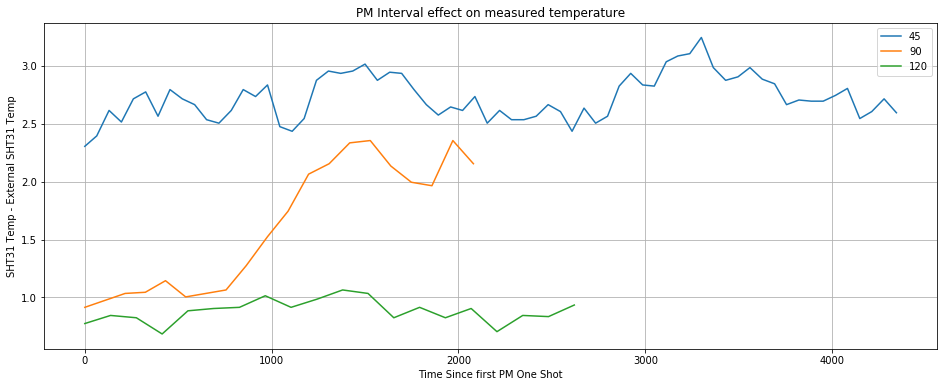

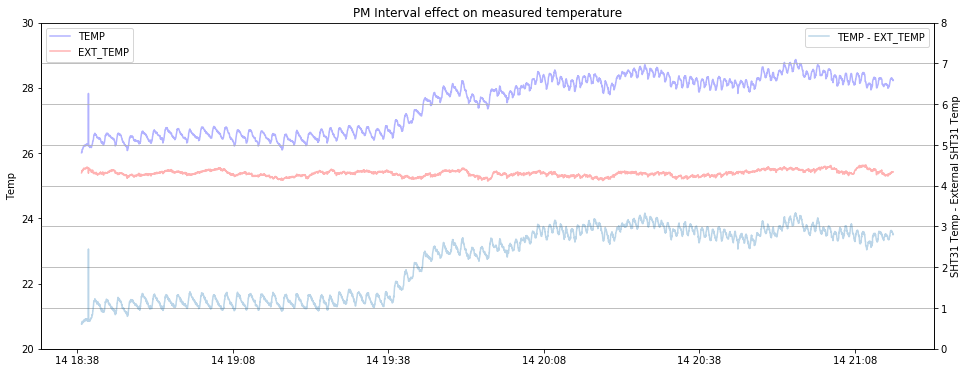

In [105]:
# Group it be 'change'
gg = [x for _, x in test_data.groupby('LENGTH_PM_ON')]

fig = plot.figure(figsize=(16,6))

initial_temp = test_data['EXT_TEMP'][0]
list_temp = list()
for i in gg:
    print 'Interval', int(i['LENGTH_PM_ON'].mean()), 'had', i.shape[0], 'items'
    initial_index = i.index[0]
    print initial_index, initial_temp
    i['DELTA_TIME'] = (i.index - initial_index).seconds
    i['DELTA_TEMP'] = i['TEMP'] - initial_temp
    #display(i.loc[:,['TEMP','DELTA_TIME', 'DELTA_TEMP']])
    plot.plot(i['DELTA_TIME'], i['DELTA_TEMP'], label = int(i['LENGTH_PM_ON'].mean()))
    list_temp.append(i.loc[i['DELTA_TIME'] > 1000 ]['DELTA_TEMP'].mean())

plot.legend(loc = 'best')
plot.grid(True)
plot.xlabel('Time Since first PM One Shot')
plot.ylabel('SHT31 Temp - External SHT31 Temp')
plot.title('PM Interval effect on measured temperature')

# I know this is a crazy way to print things, but it's funny
print 'Average delta for each delta'
print '\n'.join(str(p) for p in zip([int(i['LENGTH_PM_ON'].mean()) for i in gg], list_temp)) 

# fig = plot.figure(figsize=(16,6))
# plot.plot(test_data['TRANSITION_PM_ON_OFF'])
# # plot.xlim(['2018-11-14 20:00:00+01:00', '2018-11-14 21:03:56+01:00'])

# fig = plot.figure(figsize=(16,6))
# plot.plot(test_data['COUNTER_PM_ON_OFF'])
# # plot.xlim(['2018-11-14 20:00:00+01:00', '2018-11-14 21:03:56+01:00'])

# fig = plot.figure(figsize=(16,6))
# plot.plot(test_data['LENGTH_PM_ON'], 'ko')
# # plot.xlim(['2018-11-14 20:00:00+01:00', '2018-11-14 21:03:56+01:00'])

fig, ax1 = plot.subplots(figsize=(16,6))
ax1.plot(test_data['TEMP'],  'b', label = 'TEMP', alpha = 0.3)
ax1.plot(test_data['EXT_TEMP'], 'r', label = 'EXT_TEMP', alpha = 0.3)
ax1.set_ylabel('Temp')
ax1.legend(loc = 'upper left')
ax1.set_ylim([20, 30])
ax2 = ax1.twinx()
ax2.plot(test_data['TEMP']-test_data['EXT_TEMP'] , label = 'TEMP - EXT_TEMP', alpha = 0.3)
ax2.set_xlabel('Time (-)')
ax2.set_ylabel('SHT31 Temp - External SHT31 Temp')
ax2.set_ylim([0, 8])
plot.title('PM Interval effect on measured temperature')
ax2.grid(True)
ax2.legend(loc='upper right')
# # plot.xlim(['2018-11-14 20:00:00+01:00', '2018-11-14 21:03:56+01:00'])

# fig = plot.figure(figsize=(16,6))
# plot.plot(test_data['DIFF_TEMP'])
# plot.xlim(['2018-11-14 20:00:00+01:00', '2018-11-14 21:03:56+01:00'])

## Test with continuous PM

-------------------------------------
 Medias:

 PM_ON_OFF_FULL	EXT_TEMP	25.39
 PM_ON_OFF_FULL	TEMP	26.55
-------------------------------------
-------------------------------------
 Std Deviation:

 PM_ON_OFF_FULL	EXT_TEMP	0.07
 PM_ON_OFF_FULL	TEMP	0.14
-------------------------------------


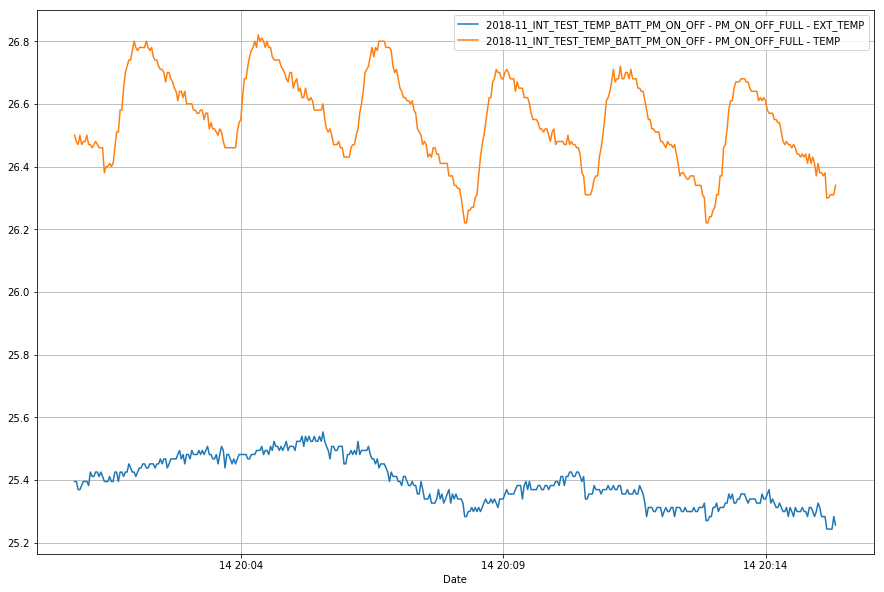

In [106]:
from IPython.display import display, Markdown, FileLink, FileLinks, clear_output, HTML
from IPython.core.display import HTML
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# --
# Plotly
import plotly as ply
import plotly.graph_objs as go
from plotly.widgets import GraphWidget
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls

import matplotlib.pyplot as plot

init_notebook_mode(connected=True)

# Plot Y limits
setLimits = False
maxY = 15000
minY = 0

toshow = []
axisshow = []
# meanTable = []

def show_devices(Source):
    _device.options = [s for s in list(readings[Source]['devices'].keys())]
    _device.source = Source
    #_min_date.value = readings[Source].index.min()._short_repr
    #_max_date.value = readings[Source].index.max()._short_repr

def show_sensors(Source):
    _sensor_drop.options = [s for s in list(readings[_test.value]['devices'][Source]['data'].columns)]
    _sensor_drop.source = Source
    _min_date.value = readings[_test.value]['devices'][Source]['data'].index.min()._short_repr
    _max_date.value = readings[_test.value]['devices'][Source]['data'].index.max()._short_repr

def clear_all(b):
    clear_output()
    del toshow[:]
    del axisshow[:]

def add_sensor(b):
    clear_output()
    d = [_device.source, _sensor_drop.source, _sensor_drop.value]
    
    if d not in toshow: 
        toshow.append(d)
        axisshow.append(_axis_drop.value)
        
    plot_data = readings[toshow[0][0]]['devices'][toshow[0][1]]['data'].loc[:,(toshow[0][2],)]
    list_data_primary = []
    list_data_secondary = []
    list_data_terciary = []
    
    if b.slice_time:
        plot_data = plot_data[plot_data.index > _min_date.value]
        plot_data = plot_data[plot_data.index < _max_date.value]
    
    if len(toshow) > 1:
        for i in range(1, len(toshow)):
            plot_data = pd.merge(plot_data, readings[toshow[i][0]]['devices'][toshow[i][1]]['data'].loc[:,(toshow[i][2],)], left_index=True, right_index=True)
    # plot_data = plot_data.groupby(pd.Grouper(freq='10Min')).aggregate(np.mean)    

    print ('-------------------------------------')
    print (' Medias:\n')
    meanTable = []
    for d in toshow:
        myMean = ' ' + d[1]  + "\t" + d[2] + "\t"
        meanTable.append(myMean)   
    res = plot_data.mean()
    for i in range(len(meanTable)): print (meanTable[i] + '%.2f' % (res[i]))
    print ('-------------------------------------')
    
    print ('-------------------------------------')
    print (' Std Deviation:\n')
    stdTable = []
    for d in toshow:
        myStd = ' ' + d[1]  + "\t" + d[2] + "\t"
        stdTable.append(myStd)   
    std = plot_data.std()
    for i in range(len(stdTable)): print stdTable[i] + '%.2f' % (std[i])
    print ('-------------------------------------')

    # Change columns naming
    changed = []
    for i in range(len(plot_data.columns)):
        changed.append(toshow[i][0] + ' - '+ toshow[i][1] + ' - '+ plot_data.columns[i])
    plot_data.columns = changed
    
    subplot_rows = 0
    if len(toshow) > 0:
        for i in range(len(toshow)):
            if axisshow[i]=='1': 
                list_data_primary.append(str(changed[i]))
                subplot_rows = max(subplot_rows,1)
            if axisshow[i]=='2': 
                list_data_secondary.append(str(changed[i]))
                subplot_rows = max(subplot_rows,2)
            if axisshow[i]=='3': 
                list_data_terciary.append(str(changed[i]))
                subplot_rows = max(subplot_rows,3)
          
    
    if _matplotly.value == 'Plotly':
        fig1 = tls.make_subplots(rows=subplot_rows, cols=1, shared_xaxes=_synchroniseXaxis.value)
    
        #if len(list_data_primary)>0:
            #fig1 = plot_data.iplot(kind='scatter', y = list_data_primary, asFigure=True, layout = layout)
        #ply.offline.iplot(fig1)
        
        for i in range(len(list_data_primary)):
            fig1.append_trace({'x': plot_data.index, 'y': plot_data[list_data_primary[i]], 'type': 'scatter', 'name': list_data_primary[i]}, 1, 1)
    
        for i in range(len(list_data_secondary)):
            fig1.append_trace({'x': plot_data.index, 'y': plot_data[list_data_secondary[i]], 'type': 'scatter', 'name': list_data_secondary[i]}, 2, 1)
        
        for i in range(len(list_data_terciary)):
            fig1.append_trace({'x': plot_data.index, 'y': plot_data[list_data_terciary[i]], 'type': 'scatter', 'name': list_data_terciary[i]}, 3, 1)
    
        if setLimits: 
            fig1['layout'].update(height = 800,
                                legend=dict(x=-.1, y=1.2) ,
                               xaxis=dict(title='Time'))
                              
        else:
            fig1['layout'].update(height = 800,
                                  legend=dict(x=-.1, y=1.2) ,
                               xaxis=dict(title='Time'))
                               
        ply.offline.iplot(fig1)
        
    elif _matplotly.value == 'Matplotlib':
        
        fig, axes = plot.subplots(subplot_rows, 1, figsize=(15,10))
        # Four axes, returned as a 2-d array
        
        if subplot_rows == 1:
            for i in range(len(list_data_primary)):
                axes.plot(plot_data.index, plot_data[list_data_primary[i]], label =  list_data_primary[i])
                axes.legend(loc='best')

        else:
            for i in range(len(list_data_primary)):
                axes[0].plot(plot_data.index, plot_data[list_data_primary[i]], label =  list_data_primary[i])
                axes[0].legend(loc='best')
                axes[0].grid(visible = True)

            for i in range(len(list_data_secondary)):
                axes[1].plot(plot_data.index, plot_data[list_data_secondary[i]], label =  list_data_secondary[i])
                axes[1].legend(loc='best')
                axes[1].grid(visible = True)

            for i in range(len(list_data_terciary)):
                axes[2].plot(plot_data.index, plot_data[list_data_terciary[i]], label =  list_data_terciary[i])
                axes[2].legend(loc='best')
                axes[2].grid(visible = True)

        plot.xlabel('Date') 
        plot.grid(visible = True)
        plot.show()
        
    
def reset_time(b):
    _min_date.value = readings[b.src.value].index.min()._short_repr
    _max_date.value = readings[b.src.value].index.max()._short_repr

layout=widgets.Layout(width='330px')

# Test dropdown
_test = widgets.Dropdown(options=[k for k in readings.keys()], 
                        layout=layout,
                        description = 'Test')

_test_drop = widgets.interactive(show_devices, 
                                Source=_test, 
                                layout=layout)

# Device dropdown
_device = widgets.Dropdown(layout=layout,
                        description = 'Device')

_device_drop = widgets.interactive(show_sensors, 
                                Source=_device, 
                                layout=layout)

# Sensor dropdown
_sensor_drop = widgets.Dropdown(layout=layout,
                               description = 'Channel')

# Buttons
_b_add = widgets.Button(description='Add to Plot', layout=widgets.Layout(width='120px'))
_b_add.on_click(add_sensor)
_b_add.slice_time = False
_b_reset_all = widgets.Button(description='Clear all', layout=widgets.Layout(width='120px'))
_b_reset_all.on_click(clear_all)

# Axis dropdown
_axis_drop = widgets.Dropdown(
    options=['1', '2', '3'],
    value='1',
    description='Subplot:',
    disabled=False,
)

# Synchronise Checkbox
_synchroniseXaxis = widgets.Checkbox(value=False, 
                                     description='Synchronise X axis', 
                                     disabled=False, 
                                     layout=widgets.Layout(width='300px'))

_matplotly = widgets.RadioButtons(
    options=['Matplotlib', 'Plotly'], value='Matplotlib',
    description='Plot Type',
    disabled=False
)

# Date fields
_min_date = widgets.Text(description='Start date:', 
                         layout=widgets.Layout(width='330px'))
_max_date = widgets.Text(description='End date:', 
                         layout=widgets.Layout(width='330px'))

# Date buttons
_b_apply_time = _b_reset = widgets.Button(description='Apply dates', layout=widgets.Layout(width='100px'))
_b_apply_time.on_click(add_sensor)
_b_apply_time.slice_time = True
_b_reset_time = _b_reset = widgets.Button(description='Reset dates', layout=widgets.Layout(width='100px'))
_b_reset_time.on_click(reset_time)
#_b_reset_time.src = _kit


_device_box = widgets.HBox([_test_drop, _device_drop])
_sensor_box = widgets.HBox([_sensor_drop, _axis_drop, _synchroniseXaxis])
_plot_type_box = widgets.VBox([_matplotly])

_plot_box = widgets.HBox([_b_add , _b_reset_all])
_time_box = widgets.HBox([_min_date,_max_date, _b_reset_time, _b_apply_time])
_root_box = widgets.VBox([_matplotly, _time_box, _device_box, _sensor_box, _plot_box])
display(_root_box)

Average Temperature difference 3.77652816574


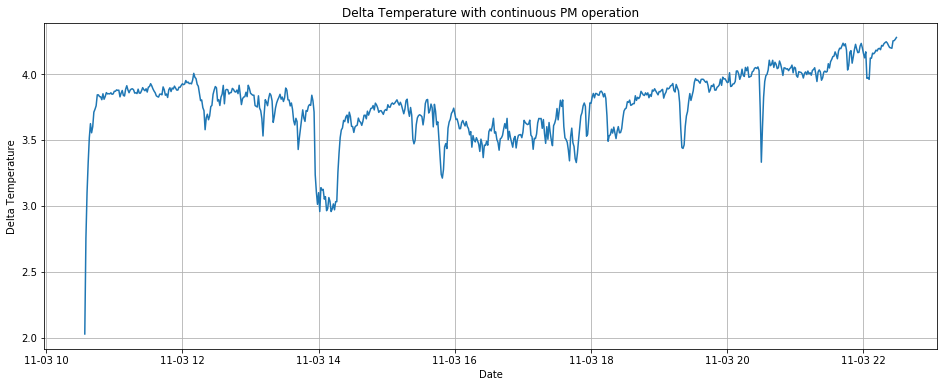

In [112]:
dataframe_cont = readings['2018-10_INT_TEST_TEMP_PM_CHARGE_SD']['devices']['CHARGE_DISCHARGE_SD_PM']['data']

dataframe_cont['DIFF_TEMP'] = dataframe_cont['TEMP'] -dataframe_cont['EXT_TEMP']
dataframe_cont = dataframe_cont[dataframe_cont.index > '2018-11-03 11:33:00']
dataframe_cont = dataframe_cont[dataframe_cont.index < '2018-11-03 23:30:00']

fig = plot.figure(figsize=(16,6))

plot.plot(dataframe_cont['DIFF_TEMP'])
plot.xlabel('Date')
plot.ylabel('Delta Temperature')
plot.title('Delta Temperature with continuous PM operation')
plot.grid(True)

print 'Average Temperature difference', dataframe_cont['DIFF_TEMP'].mean()

In [113]:
print readings.keys()


['2018-10_INT_TEST_TEMP_PM_CHARGE_SD', '2018-11_INT_TEST_TEMP_BATT_PM_ON_OFF', '2018-10_INT_TEST_TEMP_PM']
